# Week03

- [x] 实现双线性插值 
- [x] 实现直方图均衡化
- [x] 实现sobel边缘检测

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show(img, cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

class MyImage:
    '''
    读取、显示、保存、缩放(最邻近,双线性)、灰度化、二值化、
    直方图均衡化、sobel边缘检测
    '''
    __img = None

    def __init__(self, path=None):
        if path:
            self.__img = plt.imread(path)
        else:
            self.__img = None
    
    def load(self, path):
        self.__img = plt.imread(path)

    def set(self, img):
        self.__img = img

    def get(self) -> np.ndarray:
        return self.__img

    def show(self, cmap=None):
        if self.__img is None:
            raise ValueError('image is None')
        plt.imshow(self.__img, cmap=cmap)
        plt.axis('off')
        plt.show()

    def save(self, path):
        plt.imsave(path, self.__img)

    def resize(self, width, height, interpolation=cv2.INTER_LINEAR) -> np.ndarray:
        '''
        interpolation:
            cv2.INTER_NEAREST: 最近邻插值
            cv2.INTER_LINEAR: 双线性插值
            cv2.INTER_AREA: 使用像素区域关系进行重采样
            cv2.INTER_CUBIC: 4x4像素邻域的双三次插值
            cv2.INTER_LANCZOS4: 8x8像素邻域的Lanczos插值
        '''
        return cv2.resize(self.__img, (width, height), interpolation=interpolation)
        
    def resizeDIY(self, width, height, interpolation=cv2.INTER_LINEAR) -> np.ndarray:
        w, h, c = self.__img.shape
        x_ratio = w / width
        y_ratio = h / height
        img = np.zeros((width, height, c), dtype=self.__img.dtype)
        if(interpolation == cv2.INTER_NEAREST):
            for i in range(width):
                x = int(i * x_ratio)
                for j in range(height):
                    img[i, j] = self.__img[x, int(j*y_ratio)]
        elif(interpolation == cv2.INTER_LINEAR):
            for i in range(width):
                x = i * x_ratio
                x1 = int(x)
                x2 = min(x1 + 1, w - 1)
                for j in range(height):
                    y = j * y_ratio
                    y1 = int(y)
                    y2 = min(y1 + 1, h - 1)
                    img[i, j] = self.__img[x1, y1] * (x2 - x) * (y2 - y) + \
                                self.__img[x1, y2] * (x2 - x) * (y - y1) + \
                                self.__img[x2, y1] * (x - x1) * (y2 - y) + \
                                self.__img[x2, y2] * (x - x1) * (y - y1)
            # 由于 float 精度问题，可能出现非常小的负数
            if(self.__img.dtype == np.uint8):
                img = np.clip(img, 0, 255).astype(np.uint8)
            else:
                img = np.clip(img, 0, 1)     
        else:
            raise ValueError('unsupported interpolation method')
        return img

    def gray(self) -> np.ndarray:
        return cv2.cvtColor(self.__img, cv2.COLOR_RGB2GRAY)
    
    def grayDIY(self) -> np.ndarray:
        return np.dot(self.__img[...,:3], [0.299, 0.587, 0.114])
    
    def binary(self, threshold=128) -> np.ndarray:
        gray = self.gray()
        return cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)[1]
    
    def binaryDIY(self, threshold=128) -> np.ndarray:
        gray = self.grayDIY()
        return (gray > threshold) * 255

    def equalizeHist(self) -> np.ndarray:
        gray = cv2.cvtColor(self.__img, cv2.COLOR_RGB2GRAY)
        # cv2.equalizeHist只能处理CV_8UC1类型的图像
        gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        return cv2.equalizeHist(gray)
    
    def equalizeHistDIY(self) -> np.ndarray:
        gray = np.dot(self.__img[...,:3], [0.299, 0.587, 0.114])
        if(self.__img.dtype == np.uint8):
            hist, bins = np.histogram(gray.flatten(), 256, [0, 256])
        else:
            hist, bins = np.histogram(gray.flatten(), 256, [0, 1])
        cdf = hist.cumsum()
        cdf = cdf / cdf[-1]
        return np.interp(gray, bins[:-1], cdf)
    
    def sobel(self) -> np.ndarray:
        gray = cv2.cvtColor(self.__img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return cv2.magnitude(sobelx, sobely)
    
    def sobelDIY(self) -> np.ndarray:
        gray = np.dot(self.__img[...,:3], [0.299, 0.587, 0.114])
        sobelx = cv2.filter2D(gray, -1, np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]))
        sobely = cv2.filter2D(gray, -1, np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]))
        return np.sqrt(sobelx ** 2 + sobely ** 2)


In [3]:
img = MyImage("./res/lena.png")

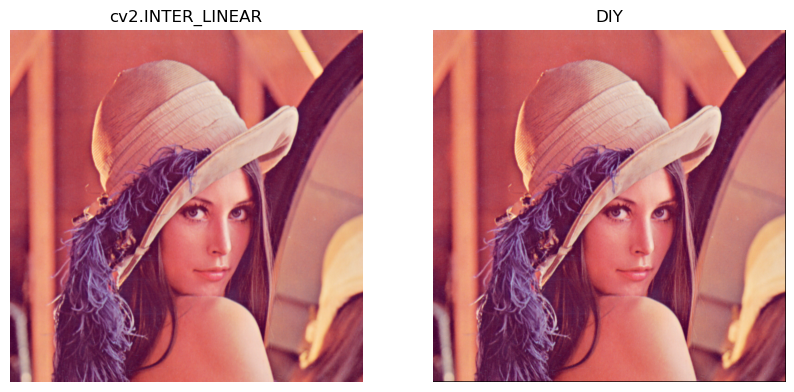

In [4]:
w, h = img.get().shape[:2]
w, h = w * 2, h * 2

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img.resize(w, h, cv2.INTER_LINEAR))
plt.axis('off')
plt.title('cv2.INTER_LINEAR')

plt.subplot(1, 2, 2)
plt.imshow(img.resizeDIY(w, h, cv2.INTER_LINEAR))
plt.axis('off')
plt.title('DIY')

plt.show()

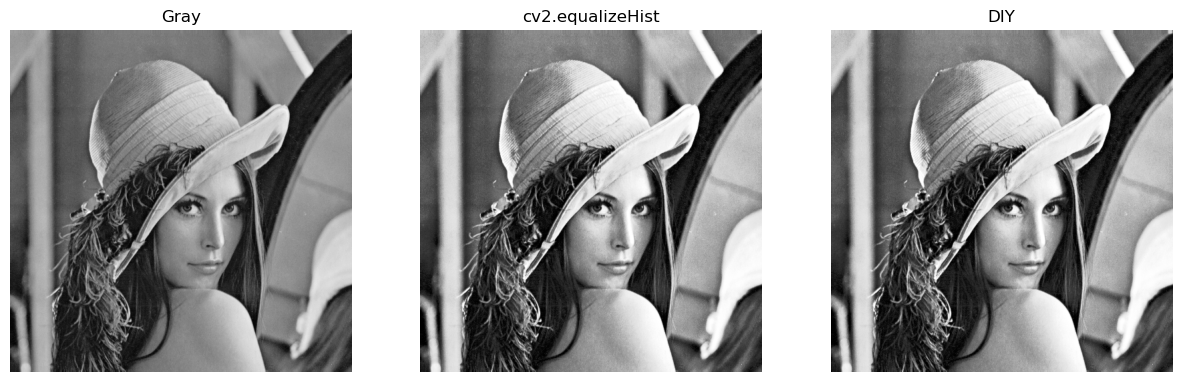

In [5]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img.gray(), cmap='gray')
plt.axis('off')
plt.title('Gray')

plt.subplot(1, 3, 2)
plt.imshow(img.equalizeHist(), cmap='gray')
plt.axis('off')
plt.title('cv2.equalizeHist')

plt.subplot(1, 3, 3)
plt.imshow(img.equalizeHistDIY(), cmap='gray')
plt.axis('off')
plt.title('DIY')

plt.show()

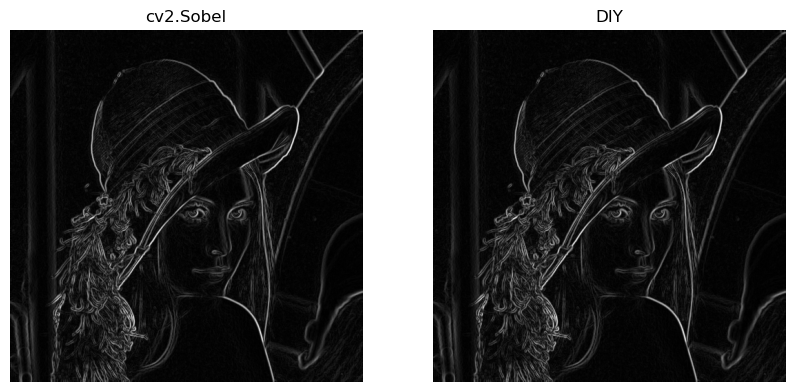

In [6]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img.sobel(), cmap='gray')
plt.axis('off')
plt.title('cv2.Sobel')

plt.subplot(1, 2, 2)
plt.imshow(img.sobelDIY(), cmap='gray')
plt.axis('off')
plt.title('DIY')

plt.show()
